Assignment 2 made by:

Niels van den Hork - s4572602

Niels van Drueten - s4496604

In [0]:
from scipy.io import loadmat
from scipy import signal
import numpy as np
import json
import matplotlib.pyplot as plt
#!pip install tqdm
from tqdm import tqdm_notebook as tqdm #if running in a notebook
#from tqdm import tqdm as tqdm #if not running in a notebook
from scipy.stats.stats import pearsonr
#from numpy import correlate as corr #not pearson 


If you're running this within googlecolab:

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/My Drive/Radboud Uni/Hardware Security/Ass2/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
KEYSIZE = 4
INPUTSIZE = 4
RANDSIZE = 4
SBox = [0xC, 0x5, 0x6, 0xB, 0x9, 0x0, 0xA, 0xD, 0x3, 0xE, 0xF, 0x8, 0x4, 0x7, 0x1, 0x2]

# Part 2
The purpose of the second part of the assignment is to perform an attack against a pro-
tected implementation. A common technique to protect a cryptographic implementation
against side-channel analysis is masking, which randomizes the key-dependent interme-
diate values. For instance, the input plaintext in is split into 2 values in0; in1. For
the splitting, we need to generate a random number r0, compute in1 = in  r0 and set
in0 = r0. We can verify the correctness of the scheme by observing that the shares in0
and in1 can be recombined via a XOR operation into the original input plaintext in (i.e.
in = in0 in1). After the splitting, we proceed with the KeyAddition and Substitution
layers of the cipher as shown in the following picture. In order to maintain the correct-
ness of the masking scheme (i.e. ensure that y = y0 y1), we need to alter the structure
of the Substitution layer and introduce lookup tables A and B. All intermediate values
shown in the gure are 4-bit values (nibbles). 

![image.png](https://i.imgur.com/GLdPa6X.png)

Focusing on the Substitution layer, lookup table S is the Sbox used in the
PRESENT cipher, mapping a 4-bit input to a 4-bit output as specied in
http://lightweightcrypto.org/present/present_ches2007.pdf.
Lookup table A is a random and secret lookup table, mapping an 8-bit input to a 4-bit
output. In the gure, table A receives values x0; x1 and produces A(x0jjx1), where jj
denotes concatenation. The lookup table B maps an 8-bit input to a 4-bit output. It
receives x0; x1 and produces S(x0x1)A(x0jjx1). We can then verify that y = y0y1,
i.e. the Substitution layer is carried out correctly.
In this part, you need to analyze the simulated traceset that corresponds to the gure
above.

# Step 1
The traceset contains only the leakage produced after the Substitution layer, i.e.
the leakage stemming from processing y0 and y1. The leakage model used in the
simulation is the identity model, i.e. leakage(value) = value. The values y0 and
y1 are processed at dierent points in time, i.e. they leak in two dierent time
samples and univariate (single-sample) techniques will fail to recover the key.

Input: 
 [[13]
 [ 0]
 [15]
 ...
 [ 3]
 [ 3]
 [12]] (2000, 1)


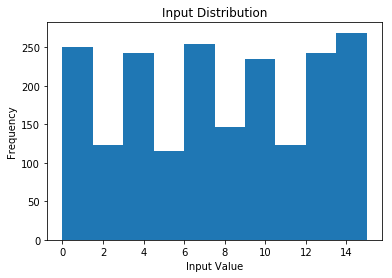

In [6]:
# Opens "hardware_traces.mat" file.
file = loadmat('input.mat')
inp = file['input'] #contains 10.000 traces, 2k samples each, 8bit(?) values

print("Input: \n {} {}".format(inp, inp.shape))

plt.hist(inp[:,0])
plt.title('Input Distribution')
plt.xlabel('Input Value')
plt.ylabel('Frequency')
plt.show()

Input: 
 [[14.16270976  2.91632453  7.96179668 ...  7.06248657 16.24544699
  14.31130687]
 [-2.570786    2.75747492  0.10349292 ... 10.60664492 14.30622662
  20.83632969]
 [23.77889391 10.42298313  8.21299228 ... 14.99281522 22.14938167
  17.40779653]
 ...
 [-1.26234725  2.76264826  8.49836706 ...  5.72712915 16.00690982
  10.66756802]
 [ 1.38394178 10.83487097 13.7344784  ... 12.60464739  7.96479836
  -0.33711087]
 [11.80083935  2.52247751  9.04856626 ... 13.07985829 11.65661399
  11.38697587]] (2000, 10)


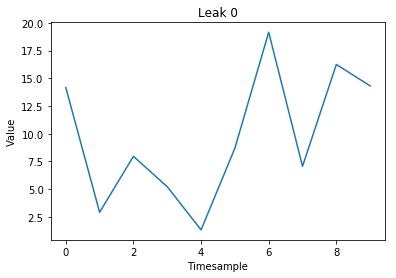

In [7]:
# Opens "hardware_traces.mat" file.
file = loadmat('leakage_y0_y1.mat')
#print(file)
leaks = file['L'] #contains 10.000 traces, 2k samples each, 8bit(?) values

print("Input: \n {} {}".format(leaks, leaks.shape))

plt.plot(leaks[0])
plt.title('Leak 0')
plt.xlabel('Timesample')
plt.ylabel('Value')
plt.show()

# Step 2
In order to perform a 2nd-order attack in this scenario, you need to perform a
pre-processing step where different sample points are combined. Thus, you need
to create a new traceset that contains all possible multiplications between the
available samples.
For example, trace t = (t0; t1; t2) will be replaced by t0 = (t0  t1; t0  t2; t1  t2). In
general, the dimension of t0 will be
􀀀m
k

, where m the number of samples (m = 10)
and k the attack order (k = 2). (Hint: use the nchoosek MATLAB function).

leak 0: [14.16270976  2.91632453  7.96179668  5.22019184  1.32559366  8.69575823
 19.15057041  7.06248657 16.24544699 14.31130687] (2000, 10)
trace 0: [ 41.30305793 112.7606156   73.93206189  18.7739983  123.15550006
 271.2239705  100.02394754 230.07955071 202.68688555  23.21918298
  15.22377351   3.86586132  25.35965307  55.84927828  20.59650285
  47.37699559  41.73641531  41.56210603  10.55410722  69.23385905
 152.4729479   56.23008215 129.34294592 113.94371553   6.91985321
  45.39352614  99.96965129  36.86753474  84.80434974  74.70776728
  11.527042    25.38587475   9.36198744  21.53486156  18.97097768
 166.52873031  61.41367576 141.26647943 124.44766456 135.25064634
 311.10957634 274.06968981 114.73325121 101.07341259 232.49357709] (2000, 45)


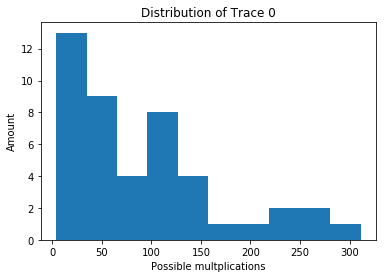

In [8]:
traces = np.zeros((2000,45)) # 10 choose 2 = 45
for idx0,trace in enumerate(leaks):
    count = 0
    for idx1,val1 in enumerate(trace):
        for idx2,val2 in enumerate(trace[idx1+1:]):
            traces[idx0][count] = val1 * val2
            count += 1
            
print('leak 0:',leaks[0],leaks.shape)
print('trace 0:', traces[0],traces.shape)
plt.hist(traces[0])
plt.title('Distribution of Trace 0')
plt.xlabel('Possible multplications')
plt.ylabel('Amount')
plt.show()

# Step 3
Assuming that y0 leaks in sample ti and y1 leaks in sample tj , then, sample ti  tj
will correlate with the key-dependent value y.

Some notes:
    
    
x1= inp^r0^k

x0= r0


y0 = A(x0||x1) = A(r0 || inp^r0^k)

y1 = S(x0^x1) ^ A(x0||x1) = S(x0^x1) ^ y0 = S(inp^k) ^ y0

y = y0 ^ y1 = S(inp^k) ^ y0 ^ y0 = S(inp^k)

The leaks contain the processing of y0 and y1.
the inputs contain inp.  


This means that y is independent from the random number and secret A.
y only depends by the Sbox, input and key.

        

# Step 4
Thus, after the trace pre-processing step, you can compute the value-prediction
matrix for value y, using all possible 4-bit key candidates and all available 4-bit
input values. (Hint: no need for power-prediction matrix, since we work under the
identity leakage model).

[ 7.  4.  2.  1. 14.  3.  8. 15.  0.  9. 13. 10.  5. 12. 11.  6.] (2000, 16)


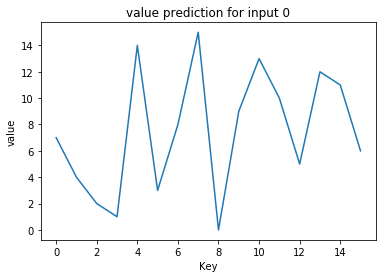

In [9]:
value_pred = np.zeros((inp.shape[0],2**KEYSIZE))
for idx1, in_ in enumerate(inp[:,0]):
    for key in range(2**KEYSIZE):
        value_pred[idx1,key] = SBox[in_^key]
        
print(value_pred[0],value_pred.shape)
plt.plot(value_pred[0])
plt.title('value prediction for input 0')
plt.xlabel('Key')
plt.ylabel('value')
plt.show()


# Step 5
Perform a correlation power analysis and find the correct key candidate. For every
sample of the new (processed) trace, plot the absolute correlation value for every
key candidate, demonstrating the leakage spike of the correct candidate.

In [0]:
def correlate_m(matrix1, matrix2):
    print(matrix1.shape,matrix2.shape)
    
    cols_matrix1 = matrix1.shape[1]
    cols_matrix2 = matrix2.shape[1]
    
    result = np.zeros((cols_matrix1,cols_matrix2))
    
    for j in tqdm(range(cols_matrix2)):
        for i in range(cols_matrix1):
            #result[i][j] = pearsonr(matrix1[:,i], matrix2[:,j])[0]
            result[i][j] = np.corrcoef(matrix1[:,i], matrix2[:,j])[0][1]
    return result


In [11]:
correlations = correlate_m(traces,value_pred)
print(correlations.shape)


(2000, 45) (2000, 16)



(45, 16)


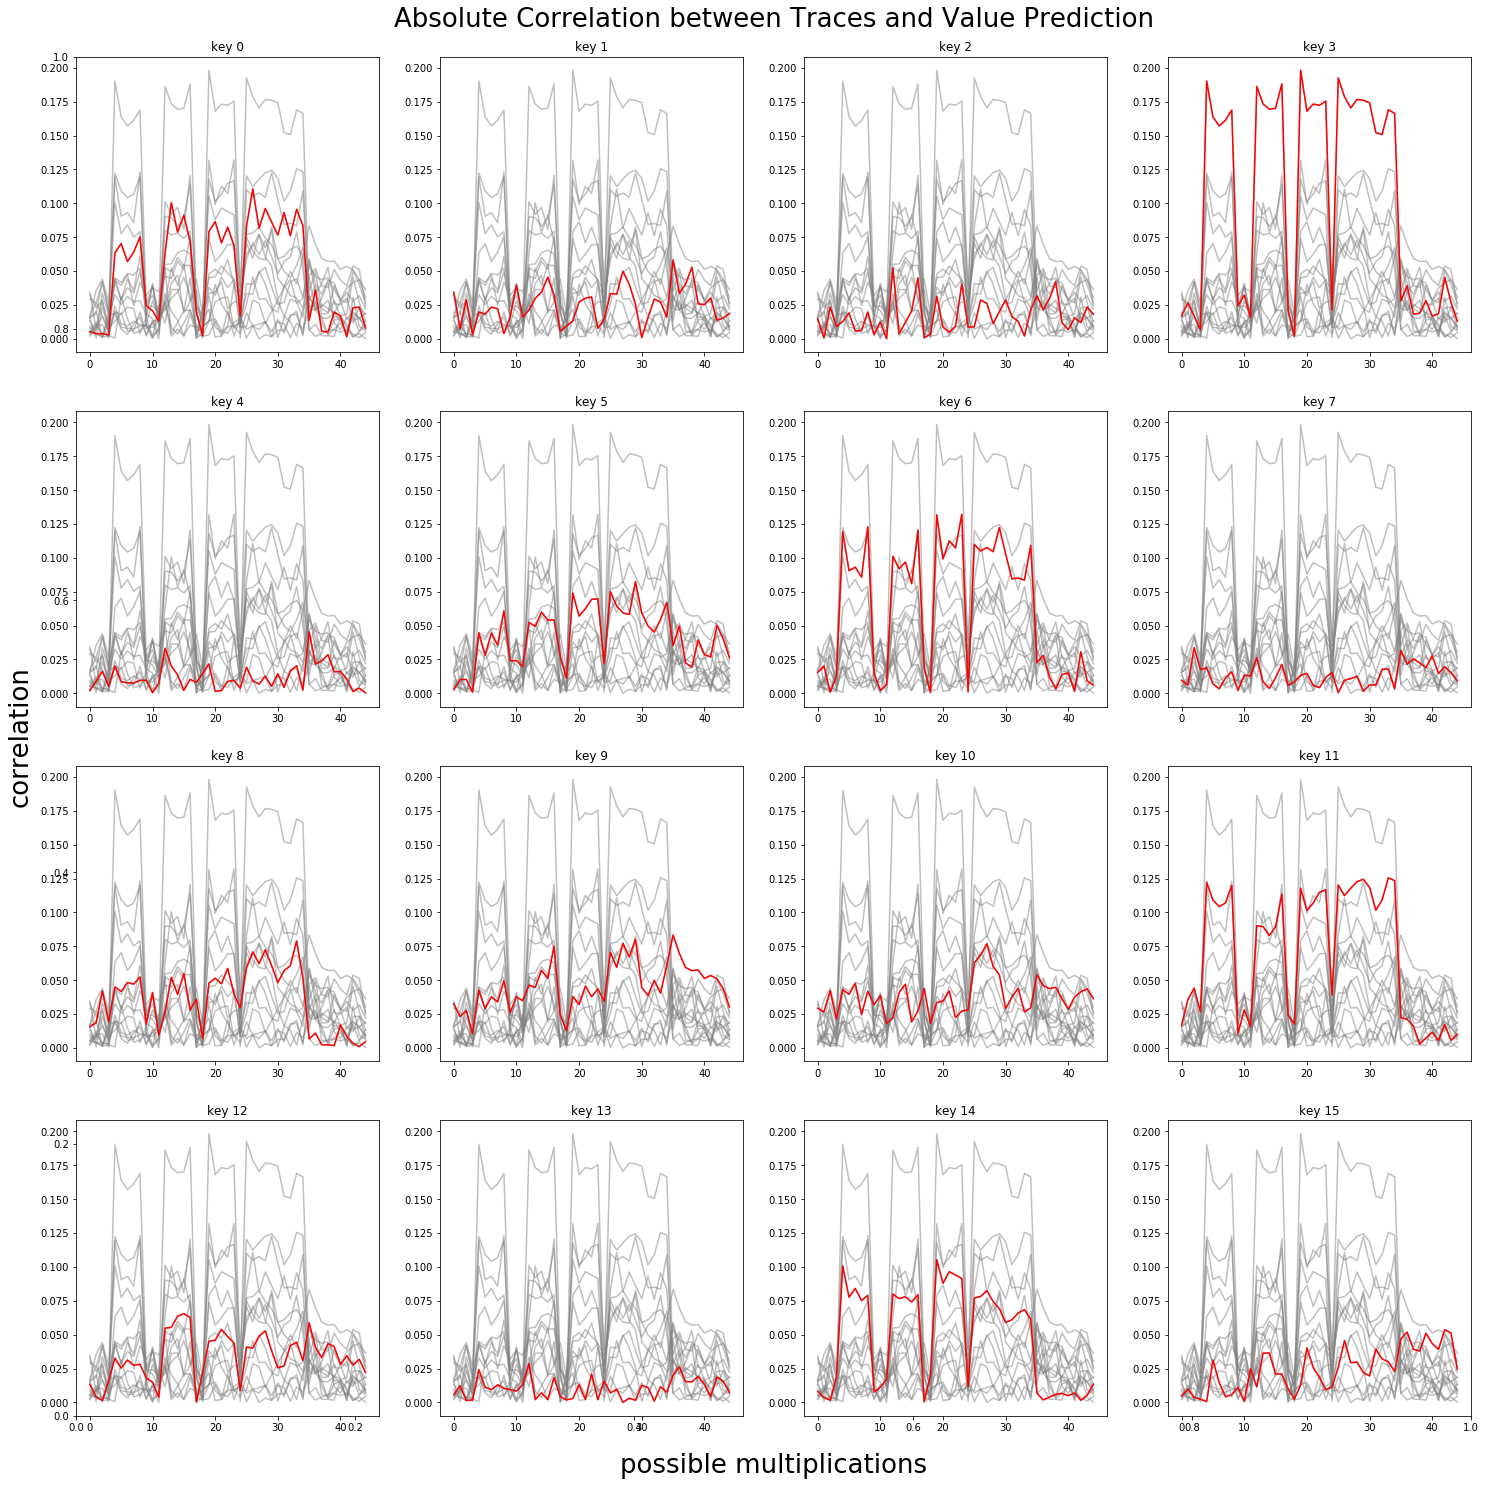

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 25, 25


fig = plt.figure()
fig.tight_layout()
main = fig.add_subplot(111,frame_on = False)

for i in range(correlations.shape[1]):
    abs_cor = np.array([abs(c) for c in correlations])
    
    ax = fig.add_subplot(4,4,i+1)
    ax.set_title('key '+str(i))
    ax.plot(abs_cor[:,:],color='gray',alpha=0.5)
    ax.plot(abs_cor[:,i],color='red')

main.set_xlabel('possible multiplications',fontsize=26,labelpad=20)
main.set_ylabel('correlation',fontsize=26,labelpad=20)
main.set_title('Absolute Correlation between Traces and Value Prediction',fontsize=26,pad=30)
plt.show()

From these plots we can clearly see that key 3 has the highest correlation